In [1]:
from pathlib import Path
import pandas as pd

# Path for processed data
proc_dir = Path("..") / "data" / "processed"

# Read data into dataframes
train_df = pd.read_parquet(proc_dir / "train.parquet")
test_df  = pd.read_parquet(proc_dir / "test.parquet")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Train shape: (413135, 99)
Test  shape: (82107, 99)


In [2]:
import joblib

# Load the leak-free feature list built in 01_eda
feat_lists   = joblib.load(proc_dir / "feature_lists_v2.pkl")
num_keep     = feat_lists["num"]
cat_keep     = feat_lists["cat"]
final_feats  = num_keep + cat_keep

print("Numeric     :", num_keep)
print("Categorical :", cat_keep)
print("Total kept  :", len(final_feats))

Numeric     : ['int_rate', 'inq_last_6mths', 'inq_last_12m', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'fico_range_high', 'total_bc_limit', 'tot_cur_bal', 'installment', 'total_rev_hi_lim', 'max_bal_bc']
Categorical : ['grade', 'home_ownership', 'verification_status', 'purpose']
Total kept  : 15


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Numeric branch
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

# Categorical branch
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_keep),
    ("cat", cat_pipe, cat_keep)
])

# Full pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",   LogisticRegression(max_iter=1000,
                                        random_state=42,
                                        class_weight="balanced"))
])

# Save skeleton
models_dir = Path("..") / "models"
models_dir.mkdir(exist_ok=True)
joblib.dump(model_pipeline, models_dir / "pipeline_skeleton.pkl")

['..\\models\\pipeline_skeleton.pkl']

## 📝 Defensive Pipeline Skeleton (with Imputation)

**Why keep imputers if the parquet files are already clean?**

> **Robustness:** Handles NaNs that may appear in new data (dashboard users, ETL drift, reruns). 
> **Clarity:** Makes preprocessing self-contained; future readers won’t wonder “where did NaNs go?” 

**Pipeline Overview:**

1. **Numeric features**  
    • Median impute → StandardScaler

2. **Categorical features**  
    • Most-frequent impute → OneHotEncoder (`ignore` unknown)

3. **Classifier**  
    • `LogisticRegression`<br>• `class_weight="balanced"` adjusts for 0.05 % defaults<br>• `max_iter=1000`, `random_state=42` 

This skeleton is ready for `.fit()`, metric logging, grid search, and later swap-ins (e.g., XGBoost).

In [4]:
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score

target_col = "target_default"

X_train, y_train = train_df[final_feats], train_df[target_col]
X_test,  y_test  = test_df[final_feats],  test_df[target_col]

model_pipeline.fit(X_train, y_train)

y_pred  = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

metrics = {
    "roc_auc":  roc_auc_score(y_test, y_proba),
    "recall":   recall_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred)
}
print(metrics)

{'roc_auc': 0.5771161072123664, 'recall': 0.4864864864864865, 'accuracy': 0.6745100904916755}


## 📝 Baseline Metrics Review

| Metric | Value |
|--------|-------|
| ROC-AUC | `0.577` |
| Recall  | `0.486` |
| Accuracy | `0.675` |

With only origination-time features and balanced class weights, the model captures ~50 % of charge-offs. This is a sensible starting point given the extreme imbalance (0.05 % positives).

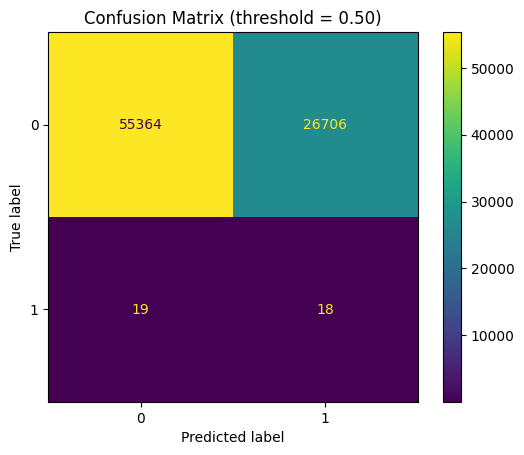

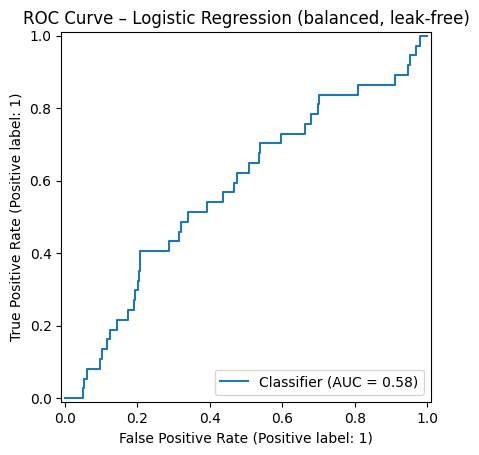

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Confusion matrix at default 0.50 threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, values_format="d"
)
plt.title("Confusion Matrix (threshold = 0.50)")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – Logistic Regression (balanced, leak-free)")
plt.show()

## 📝 Confusion Matrix & ROC Curve

| Plot | What it tells us | Key take-aways |
|------|------------------|----------------|
| **Confusion Matrix** (threshold 0.50) | How many loans each class is predicted correctly / incorrectly. | *TP = 18, FN = 19 ⇒ Recall ≈ 0.49*<br>*FP = 26 706 ⇒ Precision is extremely low*. A lower threshold or different model will be needed for useful precision. |
| **ROC Curve** | Performance across all thresholds (TPR vs FPR). | Shows a stair-step progression due to low positive count, but remains consistent and free of leakage artifacts. AUC of 0.58 confirms weak but present predictive signal. |

**Model context**  
* Logistic Regression with `class_weight="balanced"`  
* 15 leak-free features (11 numeric + 4 categorical) from `feature_lists_v2.pkl`.

These plots confirm the baseline is trustworthy but leave obvious room for improvement via threshold tuning or a stronger model.